In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import time
from timeit import default_timer as timer
import torch
from torch.autograd import Variable

import numpy as np
import pickle

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor

cuda not available


In [2]:
from core.DimReduction import DimReduction
from core.GraphConvNet2 import GraphConvNet2
from core.DataEmbeddingGraph import DataEmbeddingGraph
from util.mnist_data_loader import get_train_set, get_test_set
from util.plot_embedding import plot_embedding, plot_embedding_subplot
from util.draw_random_subset import draw_random_subset

cuda not available


In [3]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

In [4]:
dim_reduction = DimReduction(n_components=2)

In [5]:
task_parameters = {}
task_parameters['flag_task'] = 'clustering'
task_parameters['reduction_method'] = 'tsne'
task_parameters['n_components'] = 2

net_parameters = {}
net_parameters['D'] = 784
net_parameters['n_components'] = task_parameters['n_components']
net_parameters['H'] = 50
net_parameters['L'] = 10

In [6]:
net = GraphConvNet2(net_parameters, task_parameters)
print(net)


nb of hidden layers= 10
dim of layers (w/ embed dim)= [784, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]


GraphConvNet2(
  (gnn_cells): ModuleList(
    (0): GraphConvNetcell(
      (Ui1): Linear(in_features=784, out_features=50, bias=False)
      (Uj1): Linear(in_features=784, out_features=50, bias=False)
      (Vi1): Linear(in_features=784, out_features=50, bias=False)
      (Vj1): Linear(in_features=784, out_features=50, bias=False)
      (Ui2): Linear(in_features=50, out_features=50, bias=False)
      (Uj2): Linear(in_features=50, out_features=50, bias=False)
      (Vi2): Linear(in_features=50, out_features=50, bias=False)
      (Vj2): Linear(in_features=50, out_features=50, bias=False)
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R): Linear(in_features=784, out_features=50, bias=False)
    )
    (1): GraphConvNetcell(
      (Ui1): Linear(i

In [7]:
# optimization parameters
opt_parameters = {}
opt_parameters['learning_rate'] = 0.00075   # ADAM
opt_parameters['max_iters'] = 5000   
opt_parameters['batch_iters'] = 100

if 1==1: # fast debugging
    opt_parameters['max_iters'] = 500 
    opt_parameters['batch_iters'] = 50
opt_parameters['decay_rate'] = 1.25   

In [8]:
# Load Mnist dataset
data_dir = 'data/mnist'
train_data = get_train_set(data_dir)
test_data = get_test_set(data_dir)

In [9]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: data/mnist
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

In [10]:
# Initialise train_loader based on batch size
batch_size = 500

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=2, pin_memory=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True,
                                          num_workers=2, pin_memory=False)

In [11]:
# Preprocess train data to obtain embedding matrices
max_samples = 10000

all_stored_data = []
for batch_idx, (inputs, labels) in enumerate(train_loader):
    if batch_idx * batch_size > max_samples: break
        
    # Unroll image vector
    X_train = inputs.view(inputs.shape[0], -1).numpy()

    # Package into graph block
    G = DataEmbeddingGraph(X_train, labels, task_parameters['reduction_method'])
    
    all_stored_data.append(G)

In [12]:
# Optimization parameters
learning_rate = opt_parameters['learning_rate']
max_iters = opt_parameters['max_iters']
batch_iters = opt_parameters['batch_iters']
decay_rate = opt_parameters['decay_rate']
checkpoint_interval = max_iters/5
checkpoint_root = 'results/mnist_tsne1/'

# Optimizer
global_lr = learning_rate
global_step = 0
lr = learning_rate
optimizer = net.update(lr) 

# Statistics
t_start = time.time()
t_start_total = time.time()
average_loss_old = 1e10
running_loss = 0.0
running_total = 0

for iteration in range(0, max_iters):
    for G in all_stored_data:
        # Forward pass
        y_pred = net.forward(G)
        
        # Target embedding matrix
        y_true = G.target
        y_true = Variable(torch.FloatTensor(y_true).type(dtypeFloat) , requires_grad=False) 
        
        # Compute L2 loss
        loss = net.loss(y_pred, y_true)
        loss_train = loss.data[0]
        running_loss += loss_train
        running_total += 1

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # learning rate, print results
    if not iteration%batch_iters:
        
        t_stop = time.time() - t_start
        t_start = time.time()

        # update learning rate 
        average_loss = running_loss/ running_total
        if average_loss > 0.99* average_loss_old:
            lr /= decay_rate
        average_loss_old = average_loss
        optimizer = net.update_learning_rate(optimizer, lr)
        running_loss = 0.0
        running_total = 0

        # print results
        if 1==1:
            print('\niteration= %d, loss(%diter)= %.3f, lr= %.8f, time(%diter)= %.2f' % 
                  (iteration, batch_iters, average_loss, lr, batch_iters, t_stop))
    
    if not (iteration+1)%checkpoint_interval:
        filename = checkpoint_root + 'net' + str(int((iteration+1)/checkpoint_interval)) + '.pkl'
        save_checkpoint({
            'state_dict': net.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, filename)

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



iteration= 0, loss(50iter)= 264.240, lr= 0.00075000, time(50iter)= 51.85

iteration= 50, loss(50iter)= 154.628, lr= 0.00075000, time(50iter)= 2546.05

iteration= 100, loss(50iter)= 47.408, lr= 0.00075000, time(50iter)= 2545.93

iteration= 150, loss(50iter)= 23.885, lr= 0.00075000, time(50iter)= 2563.21

iteration= 200, loss(50iter)= 12.381, lr= 0.00075000, time(50iter)= 2557.50

iteration= 250, loss(50iter)= 9.516, lr= 0.00075000, time(50iter)= 2554.13

iteration= 300, loss(50iter)= 6.608, lr= 0.00075000, time(50iter)= 2554.30

iteration= 350, loss(50iter)= 5.422, lr= 0.00075000, time(50iter)= 2586.46

iteration= 400, loss(50iter)= 4.282, lr= 0.00075000, time(50iter)= 2575.08

iteration= 450, loss(50iter)= 4.104, lr= 0.00075000, time(50iter)= 2592.23


In [21]:
inputs, labels = draw_random_subset(train_data, num_samples=500)
inputs = inputs.view(inputs.shape[0],-1).numpy()
G = DataEmbeddingGraph(inputs, labels, task_parameters['reduction_method'])
y_pred = net.forward(G).detach().numpy()

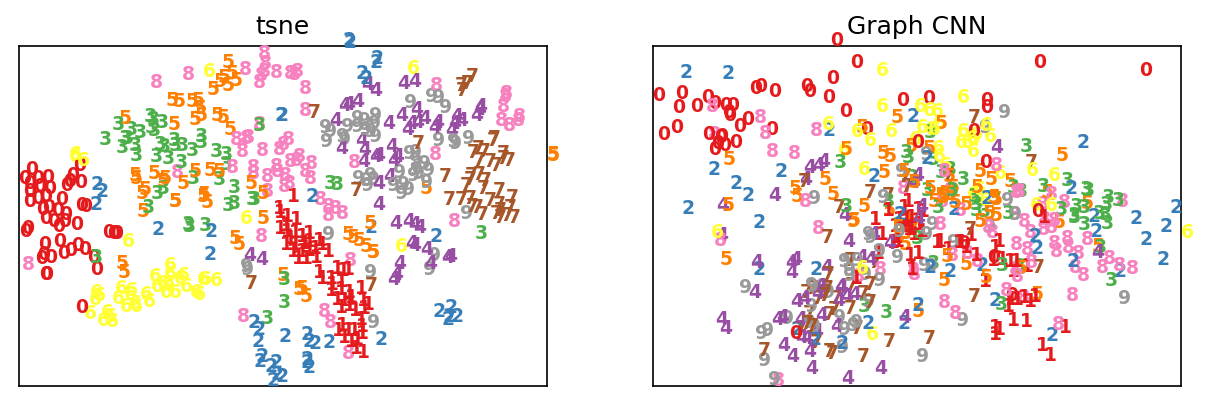

In [22]:
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), task_parameters['reduction_method'])
plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), "Graph CNN")

## On test data

In [19]:
inputs, labels = draw_random_subset(test_data, num_samples=1000)
inputs = inputs.view(inputs.shape[0],-1).numpy()
G = DataEmbeddingGraph(inputs, labels, task_parameters['reduction_method'])
net_time_start = timer()
y_pred = net.forward(G).detach().numpy()
net_time_end = timer()

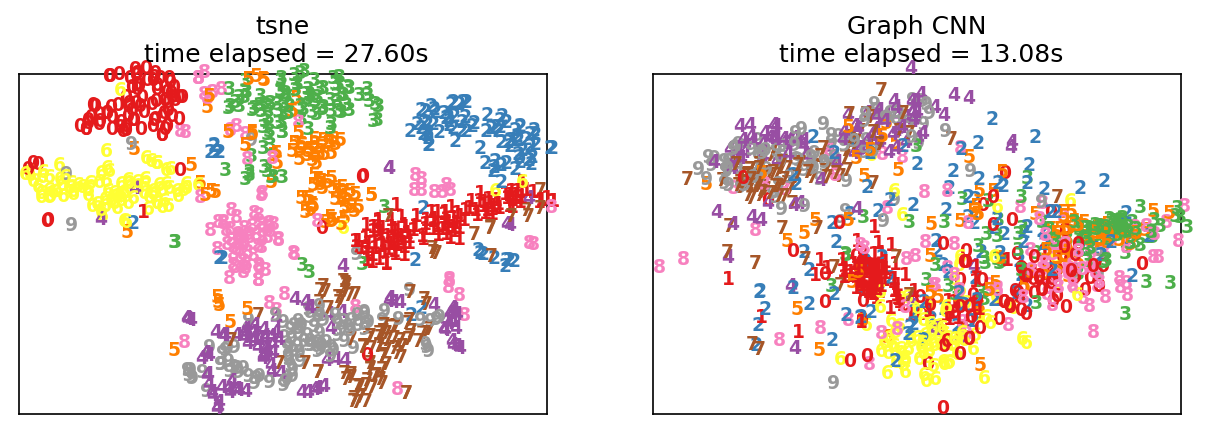

In [20]:
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
reduction_title = task_parameters['reduction_method'] + "\n time elapsed = {:.2f}s".format(G.time_to_compute) 
cnn_title = "Graph CNN" + "\n time elapsed = {:.2f}s".format(net_time_end - net_time_start) 
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), reduction_title)
plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), cnn_title)

In [24]:
import pickle
filename = 'data/mnist_10000_tsne.pkl'
with open(filename, 'wb') as f:
    pickle.dump([all_stored_data],f)